# SSM non parametrique 

In [196]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dropout,PReLU, LSTM
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Layer Personnalisé

In [169]:

class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.

    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self,X):
        self.X = X
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]  # check dimension

        # np.random.randint returns ints from [low, high) !
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]


class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.

    # Example

    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```

    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas

    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):

        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     # initializer='ones',
                                     trainable=True)

        super().build(input_shape)

    def call(self, x):
        C = tf.expand_dims(self.centers, -1)  # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))  # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Test de Base

## Tests

### Test 1 : Normaliser les données

### Test 2 - eviter l'overfitting

### Test 3 - augmenter le nombre de neurone par couches

pour 100 neurones : 100 epoch - loss : 0.0123   -> TROP FIDELE
                                       0.0130
                    50 epoch  - loss : 0.0225   -> TROP FIDELE
                                       0.0176
                    10 epoch  - loss : 15.9658  -> PAS ASSEZ
                                       15.9249
                    20 epoch  - loss : 2.8253   -> PAS DINGUE
                                       3.5893
                    30 epoch  - loss : 0.0331   -> TROP FIDELE
                                       0.0389
                    25 epoch  - loss : 0.7080  -> BOF
                                       0.5523
                                
                                    
                    
                                       

## Test sur Valeur Apple

### Tick Data

Epoch 1/10
2188/2188 [==============================] - 7s 3ms/step - loss: 0.0043 - val_loss: 0.0196
Epoch 2/10
2188/2188 [==============================] - 6s 3ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 3/10
2188/2188 [==============================] - 6s 3ms/step - loss: 5.7956e-04 - val_loss: 0.0014
Epoch 4/10
2188/2188 [==============================] - 6s 3ms/step - loss: 2.8426e-04 - val_loss: 3.1536e-04
Epoch 5/10
2188/2188 [==============================] - 6s 3ms/step - loss: 1.8911e-04 - val_loss: 9.6240e-05
Epoch 6/10
2188/2188 [==============================] - 6s 3ms/step - loss: 1.7711e-04 - val_loss: 5.0168e-05
Epoch 7/10
2188/2188 [==============================] - 6s 3ms/step - loss: 1.6091e-04 - val_loss: 3.4031e-05
Epoch 8/10
2188/2188 [==============================] - 6s 3ms/step - loss: 1.4671e-04 - val_loss: 4.1078e-05
Epoch 9/10
2188/2188 [==============================] - 6s 3ms/step - loss: 1.3651e-04 - val_loss: 5.5293e-05
Epoch 10/10
  31/3125 [.......

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3125/3125 [==============================] - 5s 2ms/step


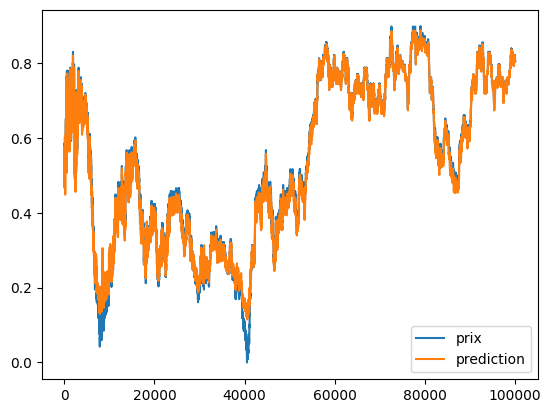

In [229]:
# Generate some random data for testing
from tensorflow.keras import regularizers

np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Forecasting-high-low-with-Kalman-filters\Appl_data.csv",sep=";",decimal=',')[["Date","price"]] #sheet_name="Feuil3"
dff = dff.rename(columns={"Date": "t", "price": "prices"})
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff['mean'] = dff.returns.rolling(30).mean()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)
scaler = MinMaxScaler()

# Appliquez la normalisation
df = scaler.fit_transform(dff)
df = pd.DataFrame(df, columns=dff.columns)


x_train = df.to_numpy()[:100000]
y_train = df.prices.to_numpy().reshape(-1,1)[1:100001]
x_test = df.to_numpy()[100000:]
y_test = df.prices.to_numpy().reshape(-1,1)[100001:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build the model
model = Sequential()
model.add(RBFLayer(output_dim=16, initializer=rbf_initializer, betas=1.0, input_shape=(5,)))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.3,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('rbf_model_test.h5')
pred = model.predict(x_train)
plt.plot(y_train, label='prix')
plt.plot(pred, label='prediction')

# Afficher la légende
plt.legend()




On teste sur le modèle sur mes données tests

5828/5828 [==============================] - 9s 1ms/step


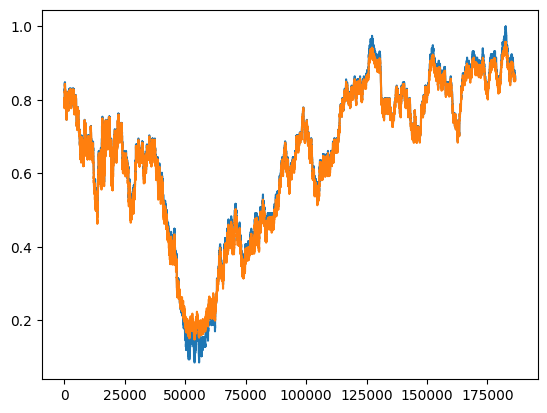

In [230]:
pred = model.predict(x_test)
plt.plot(y_test, label='prix')
plt.plot(pred, label='prediction')

Il fit super bien

### Tick data mais plus grand dataframe

Epoch 1/10
10938/10938 [==============================] - 33s 3ms/step - loss: 0.0173 - val_loss: 1.6306e-07
Epoch 2/10
10938/10938 [==============================] - 33s 3ms/step - loss: 3.8733e-07 - val_loss: 4.4549e-07
Epoch 3/10
10938/10938 [==============================] - 32s 3ms/step - loss: 5.2622e-07 - val_loss: 4.6407e-07
Epoch 4/10
10938/10938 [==============================] - 33s 3ms/step - loss: 5.2188e-07 - val_loss: 4.9212e-07
Epoch 5/10
10938/10938 [==============================] - 41s 4ms/step - loss: 5.1738e-07 - val_loss: 5.4046e-07
Epoch 6/10
10938/10938 [==============================] - 39s 4ms/step - loss: 5.1273e-07 - val_loss: 5.8949e-07
Epoch 7/10
10938/10938 [==============================] - 32s 3ms/step - loss: 5.0777e-07 - val_loss: 6.4604e-07
Epoch 8/10
10938/10938 [==============================] - 32s 3ms/step - loss: 5.0245e-07 - val_loss: 6.7526e-07
Epoch 9/10
10938/10938 [==============================] - 31s 3ms/step - loss: 4.9667e-07 - val_loss

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15625/15625 [==============================] - 26s 2ms/step


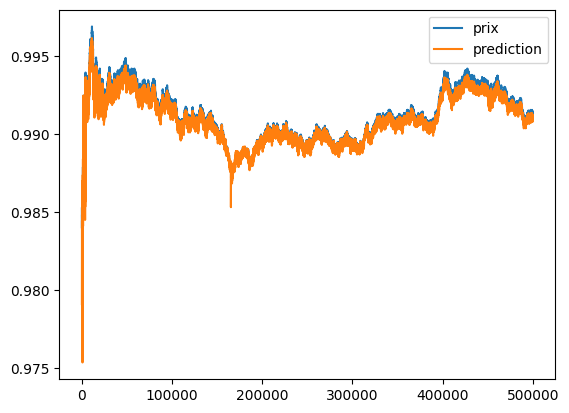

In [248]:
dff = pd.read_csv(r"C:\Users\collo\Forecasting-high-low-with-Kalman-filters\Data_apple_ibm.csv",sep=";",decimal=',',header=None) #sheet_name="Feuil3"
dff.columns=columns=['Date','Ask','Price','Tick']
dff = dff[["Date","Price"]]
dff.rename(columns={"Date": "t", "Price": "prices"},inplace=True)
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff['mean'] = dff.returns.rolling(30).mean()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)
scaler = MinMaxScaler()
# Appliquez la normalisation
df = scaler.fit_transform(dff)
df = pd.DataFrame(df, columns=dff.columns)




x_train = df.to_numpy()[:500000]
y_train = df.prices.to_numpy().reshape(-1,1)[1:500001]

x_test1 = df.to_numpy()[500000:700000]
y_test1 = df.prices.to_numpy().reshape(-1,1)[500001:700001]

x_test2 = df.to_numpy()[700000:]
y_test2 = df.prices.to_numpy().reshape(-1,1)[700001:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build the model
model1= Sequential()
model1.add(RBFLayer(output_dim=16, initializer=rbf_initializer, betas=1.0, input_shape=(5,)))
model1.add(Dense(1))


# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model1.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.3,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model1.save('rbf_model_test1.h5')
pred = model1.predict(x_train)
plt.plot(y_train, label='prix')
plt.plot(pred, label='prediction')

# Afficher la légende
plt.legend()

On teste sur les données de tests

6250/6250 [==============================] - 9s 2ms/step


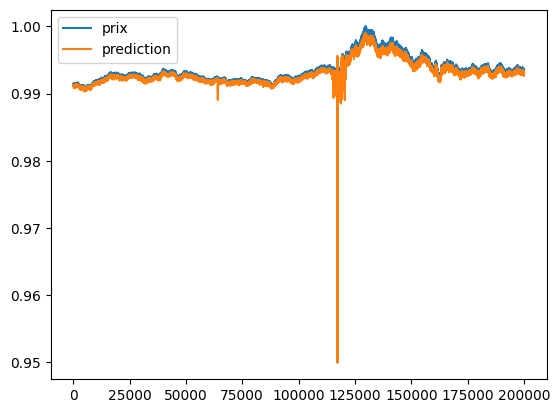

In [263]:
# Optionally, you can save the model for later use
pred = model1.predict(x_test1)
y_test1= pd.DataFrame(y_test1)
y_test1.loc[y_test1[0]<0.95,0]=0.95
pred= pd.DataFrame(pred)
pred.loc[pred[0]<0.95,0]=0.95
plt.plot(y_test1, label='prix')
plt.plot(pred, label='prediction')
plt.legend()

4458/4458 [==============================] - 7s 2ms/step


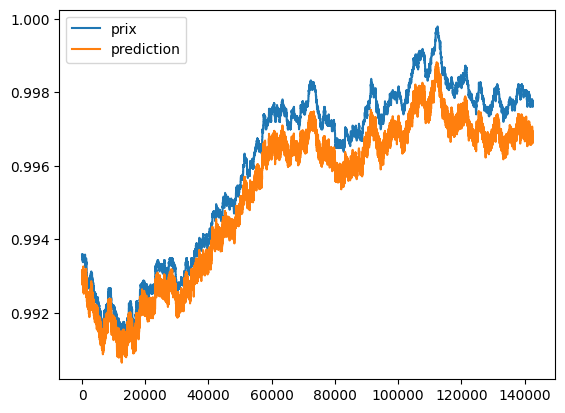

In [250]:
# Optionally, you can save the model for later use
model1.save('rbf_model_test1.h5')
pred = model1.predict(x_test2)
plt.plot(y_test2, label='prix')
plt.plot(pred, label='prediction')
plt.legend()

Il fit bien aussi :)

### Apple Data par Minute

Epoch 1/10
147/147 [==============================] - 1s 5ms/step - loss: 2.2317 - val_loss: 0.2562
Epoch 2/10
147/147 [==============================] - 1s 4ms/step - loss: 0.0679 - val_loss: 0.0511
Epoch 3/10
147/147 [==============================] - 1s 4ms/step - loss: 0.0310 - val_loss: 0.0366
Epoch 4/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0222 - val_loss: 0.0239
Epoch 5/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 6/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 7/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 8/10
147/147 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 9/10
147/147 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 10/10
 27/210 [==>...........................] - ETA: 0s 

c:\Users\collo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 0s 2ms/step


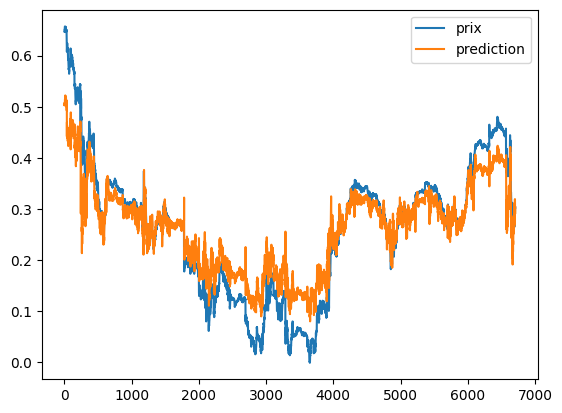

In [275]:
# Generate some random data for testing
from tensorflow.keras import regularizers

np.random.seed(23)
scaler = MinMaxScaler()
dff = pd.read_csv(r"C:\Users\collo\Forecasting-high-low-with-Kalman-filters\Data_apple_ibm1.csv",sep=";",decimal=',',header=None) #sheet_name="Feuil3"
dff.columns=columns=['Date','Price']
dff = dff[["Date","Price"]]
dff.rename(columns={"Date": "t", "Price": "prices"},inplace=True)
dff.prices=dff.prices.astype(float)
dff['returns'] = dff.prices.pct_change().fillna(0)
dff['vol'] = dff.returns.rolling(30).std()
dff['volvol'] = dff.vol.rolling(30).std()
dff['mean'] = dff.returns.rolling(30).mean()
dff.dropna(inplace=True)
dff.drop(columns=['t'],inplace=True)
scaler = MinMaxScaler()
# Appliquez la normalisation
df = scaler.fit_transform(dff)
df = pd.DataFrame(df, columns=dff.columns)


x_train = df.to_numpy()[:len(df)//2]
y_train = df.prices.to_numpy().reshape(-1,1)[1:len(df)//2+1]
x_test = df.to_numpy()[len(df)//2:-1]
y_test = df.prices.to_numpy().reshape(-1,1)[len(df)//2+1:]
# Initialize the RBFLayer with random centers from the data
rbf_initializer = InitCentersRandom(x_train)

# Build the model
model = Sequential()
model.add(RBFLayer(output_dim=24, initializer=rbf_initializer, betas=1.0, input_shape=(5,)))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
a=model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.3,
    shuffle=False,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=8,
            mode="min",
            restore_best_weights=True,
        )
    ],
    use_multiprocessing=True,
)


# Optionally, you can save the model for later use
model.save('rbf_model_test.h5')
pred = model.predict(x_train)
plt.plot(y_train, label='prix')
plt.plot(pred, label='prediction')
plt.legend()




On évalue sur les données de tests

210/210 [==============================] - 0s 2ms/step


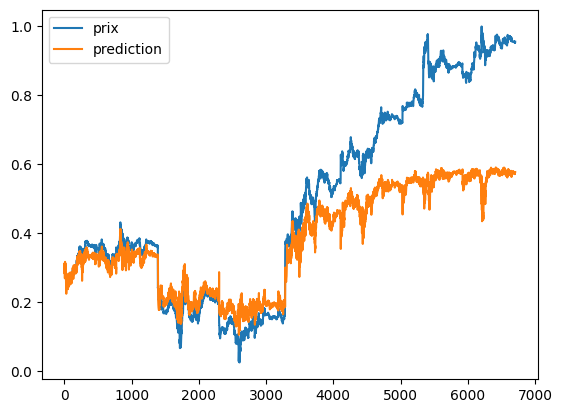

In [276]:
pred = model.predict(x_test)
plt.plot(y_test, label='prix')
plt.plot(pred, label='prediction')
plt.legend()


ça fit plutot bien

In [279]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, pred)
mse

0.0332457640729795